### Let's demonstrate the image formation pipeline in ``cryojax``.

In [1]:
# Jax imports
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import config
import starfile
config.update("jax_enable_x64", False)

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [4]:
# Image simulator imports
import cryojax.simulator as cs
from cryojax.utils import fftn, irfftn, make_frequencies
from cryojax.io import load_mrc

The match should look like this:
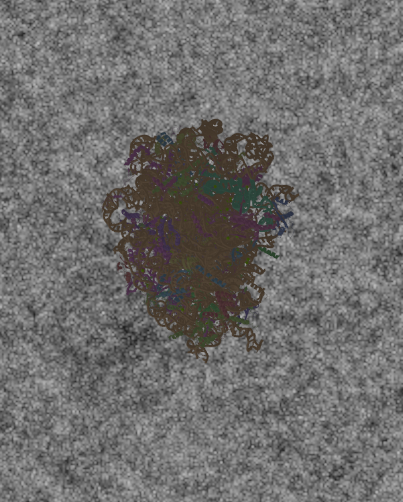

In [5]:
# Volume filename and metadata
template_filename = "/nrs/elferich/THP1_brequinar/templates/7cpu_centered_60S_200px_2.0A_bfm2.mrc"
detections_filename = "/nrs/elferich/THP1_brequinar/cistem_projects/20230505_THP1_C_g1_area4/Assets/TemplateMatching/20230505_THP1_C_g1_area4_2_tm_package_filtered_classification.star"

In [6]:
detections = starfile.read(detections_filename)
detection = detections.iloc[0]
detection

cisTEMAnglePsi                                                            256.28
cisTEMAngleTheta                                                           99.89
cisTEMAnglePhi                                                            251.31
cisTEMDefocus1                                                           10185.7
cisTEMDefocus2                                                            8403.8
cisTEMDefocusAngle                                                         69.86
cisTEMScore                                                                13.89
cisTEMScoreChange                                                           2.16
cisTEMPixelSize                                                          2.00015
cisTEMMicroscopeVoltagekV                                                  300.0
cisTEMMicroscopeCsMM                                                         2.7
cisTEMAmplitudeContrast                                                     0.07
cisTEMBeamTiltX             

Reading in tempalte and setting pose according to the starfile

In [7]:
# Read template into either an ElectronCloud or ElectronGrid
resolution = 2.0  # Angstroms
#density = cs.VoxelCloud.from_file(filename, config=dict(atol=1e-8))
density = cs.VoxelGrid.from_file(template_filename, config=dict(pad_scale=1.5))
pose = cs.EulerPose(offset_x=0.0, offset_y=0.0, view_phi=detection["cisTEMAnglePhi"], view_theta=detection["cisTEMAngleTheta"], view_psi=detection["cisTEMAnglePsi"])
specimen = cs.Specimen(density=density, pose=pose, resolution=resolution)

Creating a 200 pixel representation

In [8]:
# Configure the image formation process
shape = (200, 200)
pad_scale = 1.5
#scattering = cs.NufftScattering(shape=shape, pad_scale=pad_scale, eps=1e-5)
scattering = cs.FourierSliceScattering(shape=shape, pad_scale=pad_scale)

Set up NullDetector as detector as I don't want any noise for the cross-correlation

In [20]:
# Initialize the instrument
optics = cs.CTFOptics(defocus_u=detection["cisTEMDefocus1"], defocus_v=detection["cisTEMDefocus2"], defocus_angle=detection["cisTEMDefocusAngle"], amplitude_contrast=.07, voltage=300)
exposure = cs.UniformExposure(N=1e5, mu=0.0)
detector = cs.NullDetector(pixel_size=resolution)
instrument_o = cs.Instrument(exposure=exposure, optics=optics, detector=detector)
#instrument_o = cs.Instrument(exposure=exposure)


Finally, we can initialize our imaging model.

In [22]:
# Image formation models
optics_model = cs.ImagePipeline(scattering=scattering, specimen=specimen, instrument=instrument_o)


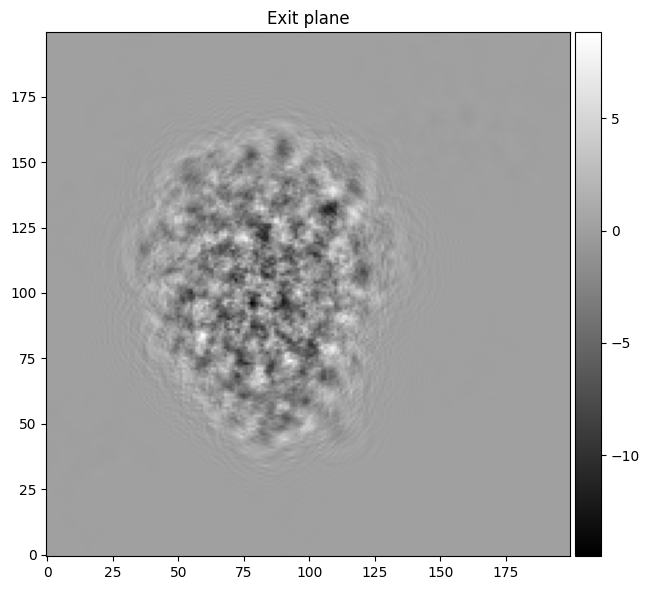

In [23]:
# Plot models
fig, axes = plt.subplots(ncols=1, figsize=(12, 6))
ax1 = axes
im1 = plot_image(optics_model(), fig, ax1, label="Exit plane")

plt.tight_layout()

Models can also include ``Filter``s. The following is a demonstration of a ``WhiteningFilter`` and a ``LowpassFilter``. These are precomputed upon initialization and applied automatically in the image formation pipeline. 

To compute a ``WhiteningFilter``, we first have to generate some synthetic data of structured noise from which we may compute its power spectrum.

/tmp/ipykernel_25837/1268908496.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


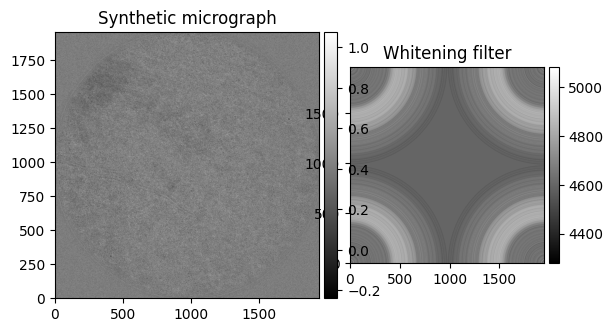

In [24]:
# Instantiate image filters
fig, axes = plt.subplot_mosaic("""
AAAABBB
""", figsize=(6.5, 3.5))
micrograph, pixel_size = load_mrc(detection["cisTEMOriginalImageFilename"])
micrograph = micrograph[0]
whiten = cs.WhiteningFilter(micrograph.shape, micrograph=micrograph)
plot_image(micrograph, fig, axes["A"], label="Synthetic micrograph")
plot_image(whiten.filter, fig, axes["B"], label="Whitening filter")
plt.tight_layout()

Now generate an image with the toy icy structured noise model with a given whitening filter. We will also apply a low pass filter for antialiasing.

(<Figure size 350x350 with 2 Axes>, <Axes: >)

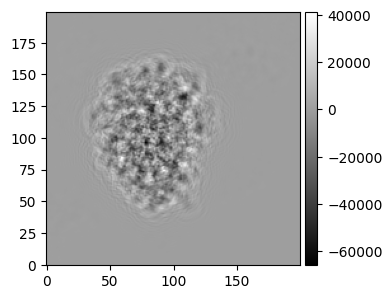

In [44]:
# Show forward model for a whitened image
fig, ax = plt.subplots(figsize=(3.5, 3.5))
filters = [cs.LowpassFilter(scattering.padded_shape, cutoff=0.95), cs.WhiteningFilter(scattering.padded_shape, micrograph=micrograph)]
filtered_model = cs.ImagePipeline(scattering=scattering, specimen=specimen, instrument=instrument_o, filters=filters)
plot_image(filtered_model(), fig, ax)

Cutting out a 200x200 subregion at the position of the match

In [39]:
cutout = micrograph[int(detection["cisTEMOriginalYPosition"]/2.0)-100:int(detection["cisTEMOriginalYPosition"]/2.0)+100, int(detection["cisTEMOriginalXPosition"]/2.0)-100:int(detection["cisTEMOriginalXPosition"]/2.0)+100]

/tmp/ipykernel_25837/1972924706.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


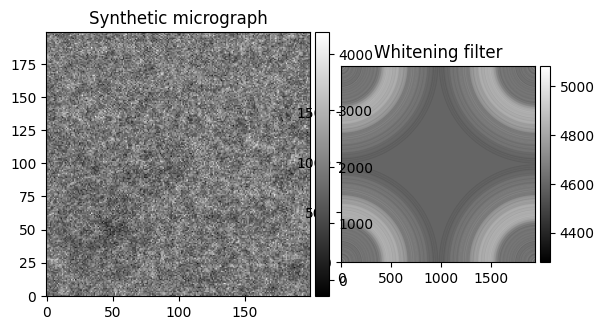

In [82]:
# Instantiate image filters
fig, axes = plt.subplot_mosaic("""
AAAABBB
""", figsize=(6.5, 3.5))

plot_image(irfftn((fftn(cutout)*cs.WhiteningFilter(scattering.shape, micrograph=micrograph).filter)), fig, axes["A"], label="Synthetic micrograph")
plot_image(whiten.filter, fig, axes["B"], label="Whitening filter")
plt.tight_layout()

Now caluclate crossocrrelation of observedxwhitening and modelxwhitening.

It would be nice if the model could render in fourier space, since that would save a round-trip here

Array(-5.65368e+10, dtype=float32)

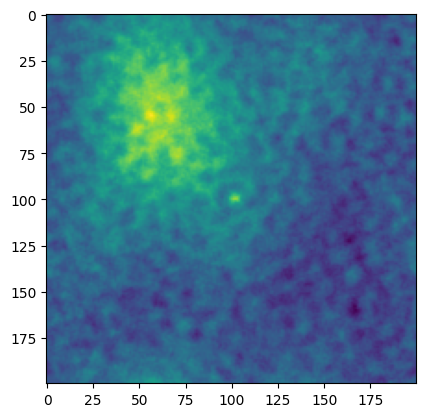

In [81]:
cc = irfftn((fftn(cutout)*cs.WhiteningFilter(scattering.shape, micrograph=micrograph).filter)*fftn(filtered_model()).conj())
plt.imshow(cc)
cc.min()

There is a central peak, but also some high cc in the background. I will create a debug version of refine-template to see if the CC-image matches.